# Making predictions with BlazeFace

This notebook shows how to use the model for face detection.

In [1]:
import numpy as np
import torch
import cv2

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.6.0
CUDA version: 10.2
cuDNN version: 7605


In [3]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

Helper code for making plots:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()

## Load the front and back models

In [5]:
from blazeface import BlazeFace

front_net = BlazeFace().to(gpu)
front_net.load_weights("blazeface.pth")
front_net.load_anchors("anchors.npy")
back_net = BlazeFace(back_model=True).to(gpu)
back_net.load_weights("blazefaceback.pth")
back_net.load_anchors("anchorsback.npy")

# Optionally change the thresholds:
front_net.min_score_thresh = 0.75
front_net.min_suppression_threshold = 0.3

/home/olivier/anaconda3/envs/BlazeConv/lib/python3.8/site-packages/torch/cuda/__init__.py:125: UserWarning: 
GeForce GT 710 with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the GeForce GT 710 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


## Make a prediction

The input image should be 128x128 for the front model and 256x256 for the back model. BlazeFace will not automatically resize the image, you have to do this yourself!

In [6]:
img = cv2.imread("1face.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
front_detections = front_net.predict_on_image(img)
front_detections.shape

torch.Size([1, 17])

In [8]:
front_detections

tensor([[0.2763, 0.3182, 0.4465, 0.4884, 0.3830, 0.3150, 0.4561, 0.3202, 0.4309,
         0.3526, 0.4229, 0.3913, 0.3182, 0.3373, 0.4769, 0.3464, 0.9308]],
       device='cuda:0')

Found 1 faces


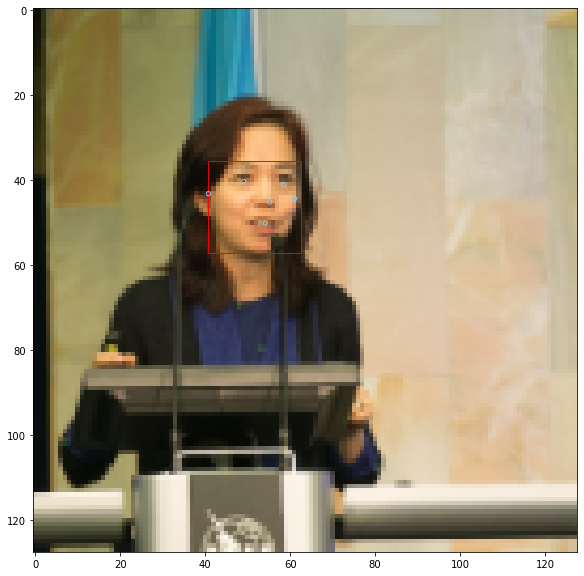

In [9]:
plot_detections(img, front_detections)

In [10]:
img2 = cv2.resize(img, (256, 256))
back_detections = back_net.predict_on_image(img2)
back_detections.shape

torch.Size([1, 17])

In [11]:
back_detections

tensor([[0.2729, 0.3162, 0.4527, 0.4960, 0.3873, 0.3154, 0.4597, 0.3212, 0.4349,
         0.3587, 0.4272, 0.3989, 0.3224, 0.3346, 0.4797, 0.3432, 0.8783]],
       device='cuda:0')

Found 1 faces


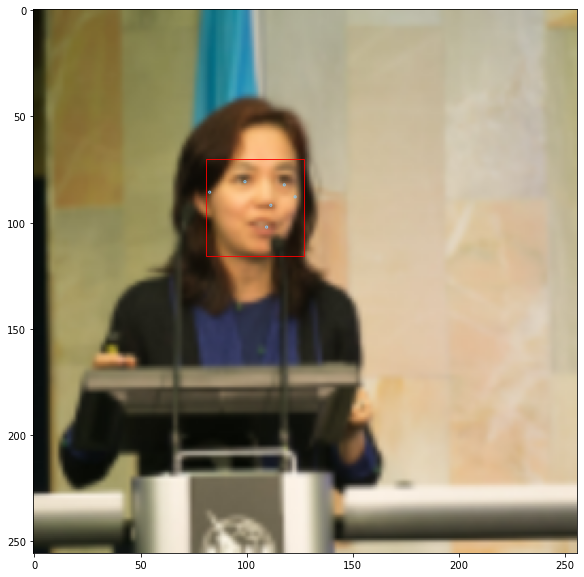

In [12]:
plot_detections(img2, back_detections)

## Make prediction on a batch of images

Load the images into a NumPy array of size `(batch, 128, 128, 3)` for front model or of size `(batch, 256, 256, 3)` for back model. Note: You could also use a PyTorch tensor here, in which case the shape must be `(batch, 3, 128, 128)` or `(batch, 3, 256, 256)`.

In [13]:
filenames = [ "1face.png", "3faces.png", "4faces.png" ]

xfront = np.zeros((len(filenames), 128, 128, 3), dtype=np.uint8)
xback = np.zeros((len(filenames), 256, 256, 3), dtype=np.uint8)

for i, filename in enumerate(filenames):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xfront[i] = img
    xback[i] = cv2.resize(img, (256, 256))

In [15]:
front_detections = front_net.predict_on_batch(xfront)
[d.shape for d in front_detections]

[torch.Size([1, 17]), torch.Size([3, 17]), torch.Size([0, 17])]

In [16]:
front_detections

[tensor([[0.2763, 0.3182, 0.4465, 0.4884, 0.3830, 0.3150, 0.4561, 0.3202, 0.4309,
          0.3526, 0.4229, 0.3913, 0.3182, 0.3373, 0.4769, 0.3464, 0.9308]],
        device='cuda:0'),
 tensor([[0.3194, 0.7767, 0.4796, 0.9368, 0.8021, 0.3703, 0.8622, 0.3622, 0.8205,
          0.4058, 0.8328, 0.4361, 0.7968, 0.3830, 0.9325, 0.3653, 0.8939],
         [0.3262, 0.4064, 0.4932, 0.5734, 0.4547, 0.3855, 0.5205, 0.3808, 0.4919,
          0.4314, 0.4947, 0.4568, 0.4172, 0.3876, 0.5595, 0.3756, 0.8460],
         [0.3303, 0.0772, 0.4807, 0.2276, 0.1245, 0.3646, 0.1893, 0.3663, 0.1596,
          0.3943, 0.1578, 0.4292, 0.0820, 0.3875, 0.2214, 0.3887, 0.8701]],
        device='cuda:0'),
 tensor([], size=(0, 17))]

Found 1 faces


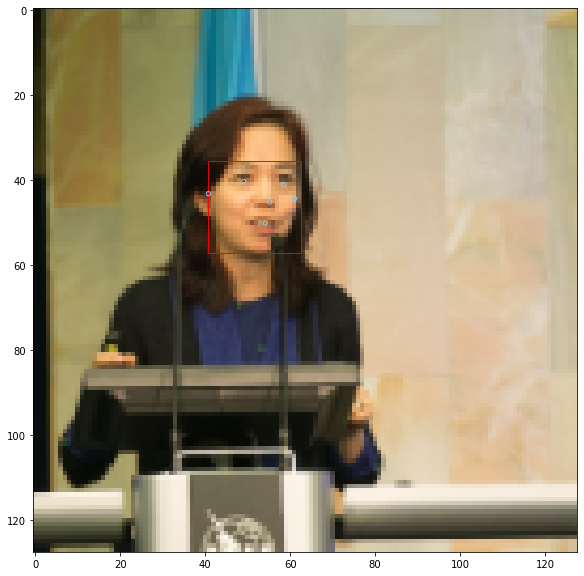

In [17]:
plot_detections(xfront[0], front_detections[0])

Found 3 faces


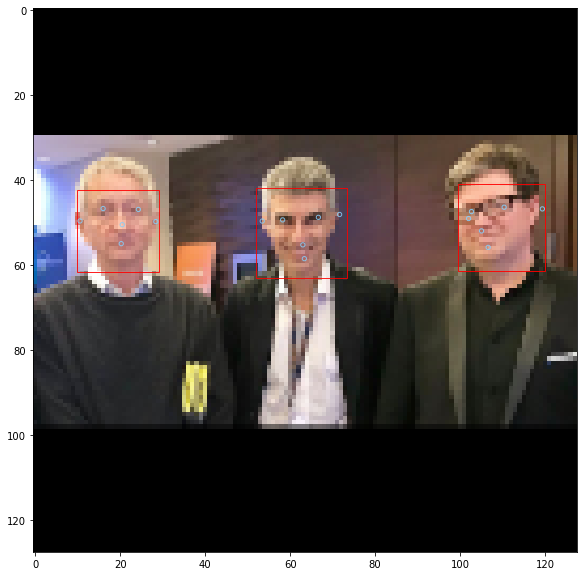

In [18]:
plot_detections(xfront[1], front_detections[1])

Found 0 faces


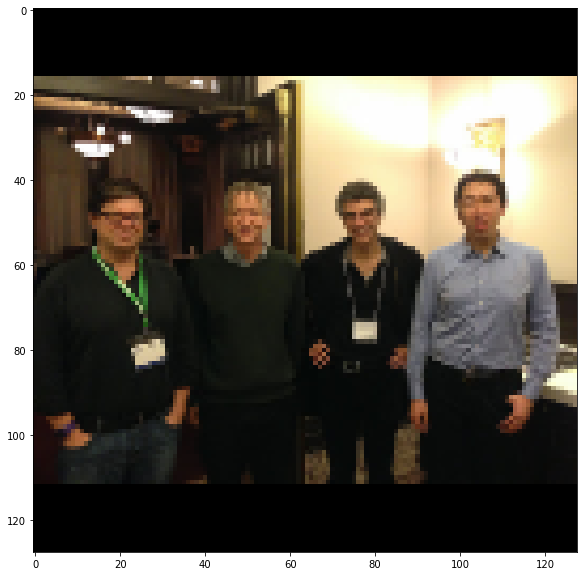

In [19]:
plot_detections(xfront[2], front_detections[2])

In [20]:
back_detections = back_net.predict_on_batch(xback)
[d.shape for d in back_detections]

[torch.Size([1, 17]), torch.Size([3, 17]), torch.Size([3, 17])]

In [21]:
back_detections

[tensor([[0.2729, 0.3162, 0.4527, 0.4960, 0.3873, 0.3154, 0.4597, 0.3212, 0.4349,
          0.3587, 0.4272, 0.3989, 0.3224, 0.3346, 0.4797, 0.3432, 0.8783]],
        device='cuda:0'),
 tensor([[0.3509, 0.4300, 0.4777, 0.5568, 0.4627, 0.3937, 0.5174, 0.3916, 0.4888,
          0.4293, 0.4912, 0.4488, 0.4368, 0.3943, 0.5521, 0.3893, 0.8168],
         [0.3336, 0.7804, 0.4642, 0.9109, 0.8029, 0.3691, 0.8574, 0.3636, 0.8212,
          0.3935, 0.8284, 0.4229, 0.7916, 0.3877, 0.9104, 0.3778, 0.8559],
         [0.3393, 0.0909, 0.4737, 0.2252, 0.1293, 0.3777, 0.1876, 0.3743, 0.1611,
          0.4077, 0.1627, 0.4354, 0.0957, 0.3924, 0.2201, 0.3842, 0.8399]],
        device='cuda:0'),
 tensor([[0.3421, 0.7887, 0.4160, 0.8626, 0.8104, 0.3593, 0.8421, 0.3600, 0.8255,
          0.3739, 0.8248, 0.3912, 0.7909, 0.3701, 0.8603, 0.3726, 0.8175],
         [0.3601, 0.5668, 0.4355, 0.6423, 0.5852, 0.3846, 0.6158, 0.3813, 0.6006,
          0.4000, 0.6036, 0.4140, 0.5722, 0.3899, 0.6393, 0.3819, 0.8296],
    

Found 1 faces


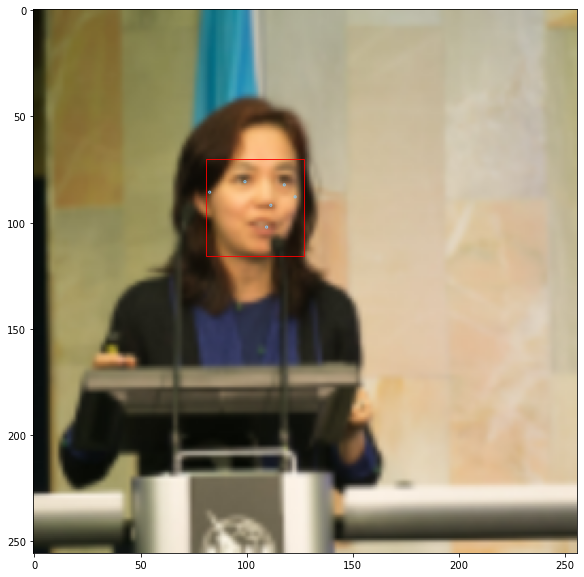

In [22]:
plot_detections(xback[0], back_detections[0])

Found 3 faces


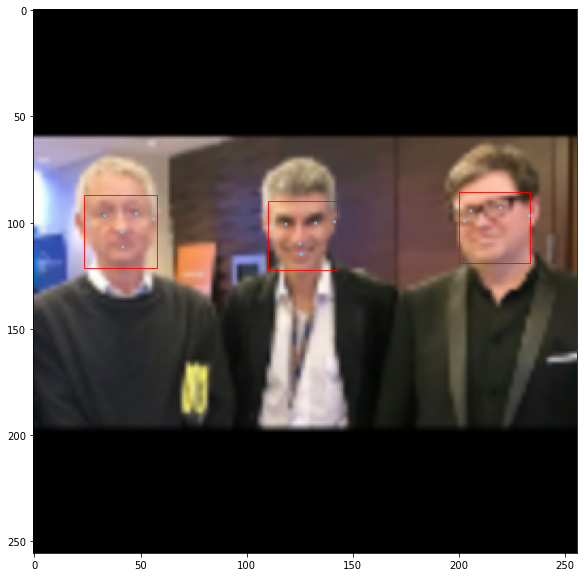

In [23]:
plot_detections(xback[1], back_detections[1])

Found 3 faces


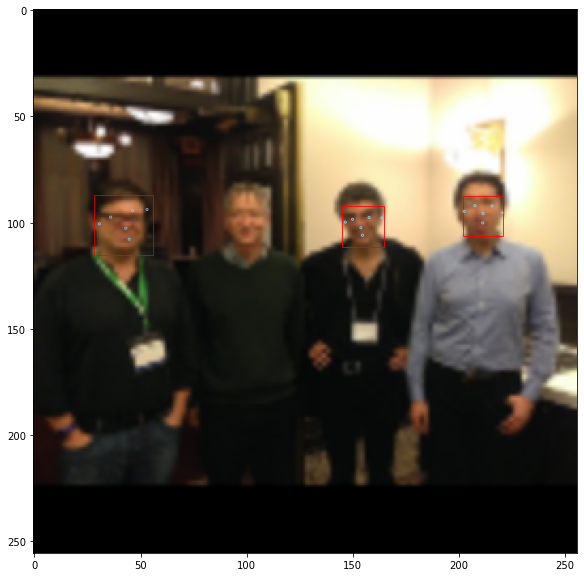

In [24]:
plot_detections(xback[2], back_detections[2])